<a href="https://colab.research.google.com/github/riscosnap/Sales-Forecast-usingLSTM-LinearRegression-ts-Model.ipynb/blob/main/Sales_Forecast_usingLSTM_LinearRegression_ts_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import os

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [109]:
sales=pd.read_csv("https://raw.githubusercontent.com/BekBrace/Sales-Forecast-data-csv/main/train.csv")

In [110]:
sales.head(6)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12


In [111]:
sales.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [112]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Converting date into datetime


In [113]:
sales['Dates']=pd.to_datetime(sales['date']) #to_datetime step is imp in timeseries data

In [114]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  object        
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
 4   Dates   913000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 34.8+ MB


In [115]:
sales.drop('date',axis=1,inplace=True)

In [116]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   store   913000 non-null  int64         
 1   item    913000 non-null  int64         
 2   sales   913000 non-null  int64         
 3   Dates   913000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [117]:
sales.dtypes

store             int64
item              int64
sales             int64
Dates    datetime64[ns]
dtype: object

In [118]:
sales=sales.drop(['store','item'],axis=1)

In [119]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   sales   913000 non-null  int64         
 1   Dates   913000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Converting Dates to Month period and to **sum the no. of items in each month**

In [120]:
sales['Dates']=sales['Dates'].dt.to_period('M') ##m

In [121]:
monthly_sales=sales.groupby('Dates').sum().reset_index() ##in monlysales varbl

In [122]:
sales['Dates'].head() #converted
               #from
               #dates.dt.to_period('M')

0    2013-01
1    2013-01
2    2013-01
3    2013-01
4    2013-01
Name: Dates, dtype: period[M]

In [123]:
sales.head(4)

,sales,Dates
0,13,2013-01
1,11,2013-01
2,14,2013-01
3,13,2013-01


In [124]:
monthly_sales.head(4)

,Dates,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274


In [125]:
monthly_sales['Dates']=monthly_sales['Dates'].dt.to_timestamp() ##back to timestamp

In [126]:
monthly_sales.head(4)

,Dates,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274


Visualization

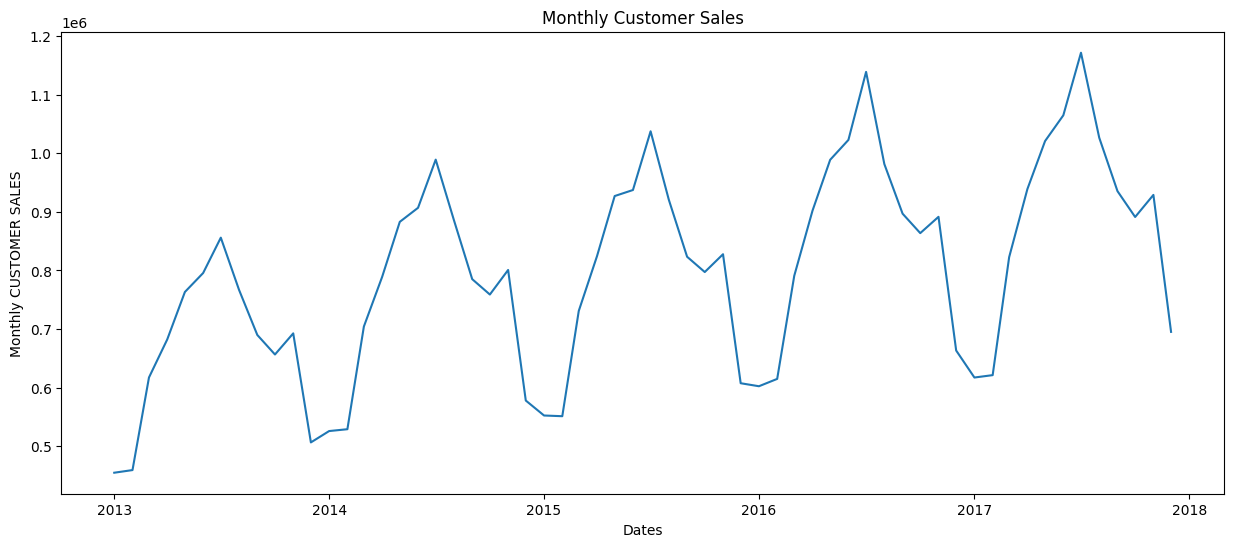

In [127]:
plt.figure(figsize=(15,6))
plt.plot(monthly_sales['Dates'],monthly_sales['sales'])
#naming x y
plt.xlabel('Dates')
plt.ylabel('Monthly CUSTOMER SALES')
plt.title('Monthly Customer Sales')
plt.show()

Call the **diffrence** ON THE SALES COLUMN  to amke this sales data *STATIONARY*

In [128]:
monthly_sales['sales-difference']=monthly_sales['sales'].diff()

In [129]:
monthly_sales=monthly_sales.dropna() #drop thenot available values and keep non null on es

In [130]:
monthly_sales.head(7)

,Dates,sales,sales-difference
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0


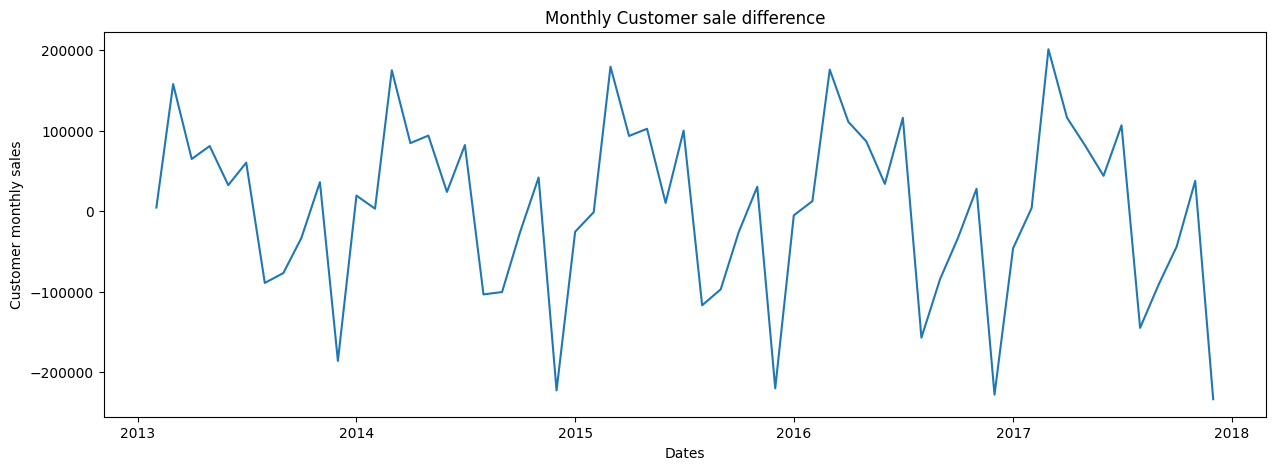

In [131]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Dates'],monthly_sales['sales-difference'])
plt.xlabel('Dates')
plt.ylabel('Customer monthly sales')
plt.title('Monthly Customer sale difference')
plt.show()

In [132]:
#movingontomodel

In [133]:
#Dropping off sales and dates to create supervised data for sales difference alone,for each month_i

In [134]:
supervised_data=monthly_sales.drop(['Dates','sales'],axis=1)

In [135]:
for i in range(1,13):
  col_name='month_'+str(i)
  supervised_data[col_name]=supervised_data['sales-difference'].shift(i)#shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)#dropna().reset_index(drop=True)
supervised_data.head(10)

,sales-difference,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Gives a better view of each month based on each sale diffrence resp.

In [136]:
#train test

In [137]:
train_data=supervised_data[:-12] #prev 12 months supervised data for train
test_data=supervised_data[-12:]  #next 12 months for test
print('train_data for prev 12 months:',train_data.shape)
print('test_data for next 12 months:',test_data.shape)

train_data for prev 12 months: (35, 13)
test_data for next 12 months: (12, 13)


In [138]:
#Scale before train test sets

In [139]:
scaled=MinMaxScaler(feature_range=(-1,1)) #featurerangeinscalerminmax
scaled.fit(train_data) ###scaledfit1
train_data=scaled.transform(train_data) ##preassign train data as scaledtranform2
test_data=scaled.transform(test_data)

In [140]:
#Makefrom train_data test_dta ,x_train,x_test,y_train,y_test Sets
x_train,y_train=train_data[:,1:],train_data[:,0:1] ##
x_test,y_test=test_data[:,1:],test_data[:,0:1]
y_train.ravel()
y_test.ravel()
print('x_train shape:',x_train.shape)
print('y_train shape:',y_train.shape)
print('x_test shape:',x_test.shape)
print('y_test shape:',y_test.shape)

x_train shape: (35, 12)
y_train shape: (35, 1)
x_test shape: (12, 12)
y_test shape: (12, 1)


In [141]:
##
sales_dates=monthly_sales['Dates'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)
act_sales=monthly_sales['sales'][-13:].to_list()

In [142]:
act_sales

[663411,
 617306,
 621369,
 822667,
 938862,
 1020686,
 1064624,
 1171393,
 1026403,
 935263,
 891160,
 928837,
 695170]

In [143]:
 #To create and predict output w LinearRegression modl

In [144]:
lr_model=LinearRegression() #to fit x,y Train sets inmodel
lr_model.fit(x_train,y_train)
lr_pre= lr_model.predict(x_test)

In [145]:
#inverse_transform for original scaled sets to unscaled(orginal form)
lr_pre=lr_pre.reshape(-1,1)
lr_pre_test_set=np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set=scaled.inverse_transform(lr_pre_test_set)

In [146]:
result_list=[]
for i in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[i][0]+act_sales[i])
lr_pre_sales=pd.Series(result_list,name='linear prediction')
predict_df=predict_df.merge(lr_pre_sales,left_index=True,right_index=True)
#since we have calculated the predicted sales values of test data we can now evaluate for linear rgression and *compare predicted w actual sale values and that is the CORE OPERATION we are doing today for future sales plans

In [147]:
#to avoid deviations in future sale plans

In [148]:
#mean_absolute_error, mean_squared_error,r2_score

In [149]:
#lr_mse=np.srt(mean_squared_error(predict_df))*use this only with name 'linear prediction'
print(predict_df)

        Dates  linear prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [150]:
lr_mse=np.sqrt(mean_squared_error(predict_df['linear prediction'],monthly_sales['sales'][-12:]))
print('LinearRegression MSE:',lr_mse)

LinearRegression MSE: 16221.272385416869


In [156]:
lr_mse=np.sqrt(mean_squared_error(predict_df['linear prediction'],monthly_sales['sales'][-12:]))
lr_mae=mean_absolute_error(predict_df['linear prediction'],monthly_sales['sales'][-12:])
lr_r2=r2_score=(predict_df['linear prediction'],monthly_sales['sales'][-12:])
print('LinearRegression MSE:',lr_mse)
print('LinearRegression MAE:',lr_mae)
print('LinearRegression R2:',lr_r2)

LinearRegression MSE: 16221.272385416869
LinearRegression MAE: 12433.184266490736
LinearRegression R2: (0     6.479148e+05
1     6.283374e+05
2     8.195190e+05
3     9.436391e+05
4     1.033653e+06
5     1.065286e+06
6     1.201561e+06
7     1.002123e+06
8     9.415142e+05
9     9.080646e+05
10    9.167461e+05
11    6.947978e+05
Name: linear prediction, dtype: float64, 48     617306
49     621369
50     822667
51     938862
52    1020686
53    1064624
54    1171393
55    1026403
56     935263
57     891160
58     928837
59     695170
Name: sales, dtype: int64)


In [154]:
lr_r2

(0     6.479148e+05
 1     6.283374e+05
 2     8.195190e+05
 3     9.436391e+05
 4     1.033653e+06
 5     1.065286e+06
 6     1.201561e+06
 7     1.002123e+06
 8     9.415142e+05
 9     9.080646e+05
 10    9.167461e+05
 11    6.947978e+05
 Name: linear prediction, dtype: float64,
 48     617306
 49     621369
 50     822667
 51     938862
 52    1020686
 53    1064624
 54    1171393
 55    1026403
 56     935263
 57     891160
 58     928837
 59     695170
 Name: sales, dtype: int64)

In [ ]:
#visualization of prediction w act


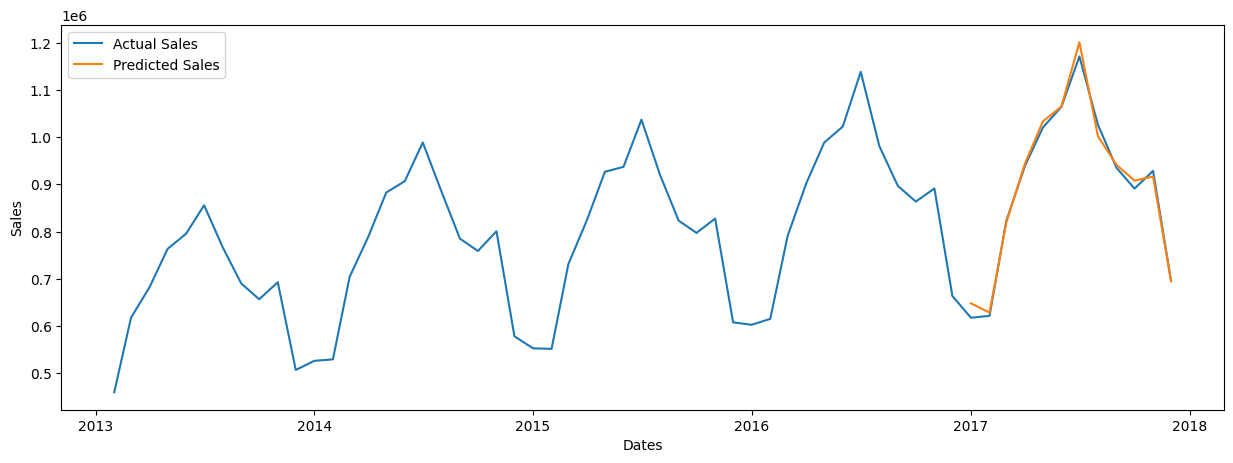

In [153]:
plt.figure(figsize=(15,5))
#Actual sales
plt.plot(monthly_sales['Dates'],monthly_sales['sales'])
#Predicted sales
plt.plot(predict_df['Dates'],predict_df['linear prediction'])
plt.xlabel('Dates')
plt.ylabel('Sales')
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()

In [ ]:
#As you can see blue line actual sales and predicted sales from 2017 to 2018
#looks like prediction is 'inline'meaning , its close, of actual sales and prediction sales. so good job